In [1]:
"""
Cell 1: Setup and Imports
All necessary libraries for data manipulation, image processing, and deep learning.
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from tqdm.auto import tqdm

# Image processing
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models

# Scikit-learn
from sklearn.model_selection import train_test_split

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
"""
Cell 2: Configuration and Data Loading
Set global constants for the model and load the raw CSV files.
"""

# --- Configuration ---
IMG_SIZE = 224
BATCH_SIZE = 16
SEED = 42
LEARNING_RATE = 1e-4
EPOCHS = 20

# *** MODIFIED: Set the base path to the Kaggle input directory ***
BASE_PATH = "/kaggle/input/csiro-biomass/"

# The 5 target columns we need to predict
TARGET_COLS = ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'GDM_g', 'Dry_Total_g']

# Weights for the evaluation metric (used in our custom loss)
EVAL_WEIGHTS = torch.tensor([0.1, 0.1, 0.1, 0.2, 0.5], dtype=torch.float32).to(DEVICE)

# --- Load Data ---
try:
    # *** MODIFIED: Join the base path with the CSV file names ***
    train_df_long = pd.read_csv(os.path.join(BASE_PATH, "train.csv"))
    test_df_long = pd.read_csv(os.path.join(BASE_PATH, "test.csv"))

    print(f"Loaded train.csv with {len(train_df_long)} rows.")
    print(f"Loaded test.csv with {len(test_df_long)} rows.")

except FileNotFoundError as e:
    print(e)
    print("Make sure 'train.csv' and 'test.csv' are in the directory specified by BASE_PATH.")

print("\n--- Raw Training Data Head ---")
print(train_df_long.head())

Loaded train.csv with 1785 rows.
Loaded test.csv with 5 rows.

--- Raw Training Data Head ---
                    sample_id              image_path Sampling_Date State  \
0  ID1011485656__Dry_Clover_g  train/ID1011485656.jpg      2015/9/4   Tas   
1    ID1011485656__Dry_Dead_g  train/ID1011485656.jpg      2015/9/4   Tas   
2   ID1011485656__Dry_Green_g  train/ID1011485656.jpg      2015/9/4   Tas   
3   ID1011485656__Dry_Total_g  train/ID1011485656.jpg      2015/9/4   Tas   
4         ID1011485656__GDM_g  train/ID1011485656.jpg      2015/9/4   Tas   

           Species  Pre_GSHH_NDVI  Height_Ave_cm   target_name   target  
0  Ryegrass_Clover           0.62         4.6667  Dry_Clover_g   0.0000  
1  Ryegrass_Clover           0.62         4.6667    Dry_Dead_g  31.9984  
2  Ryegrass_Clover           0.62         4.6667   Dry_Green_g  16.2751  
3  Ryegrass_Clover           0.62         4.6667   Dry_Total_g  48.2735  
4  Ryegrass_Clover           0.62         4.6667         GDM_g  16.2750  

In [3]:
"""
Cell 3: Reshape Data to "Wide" Format
Pivot the long-format training data into a wide-format DataFrame.
Each row will be one unique image, and columns will hold the 5 target values.
"""

def pivot_data(df):
    """Pivots the long dataframe to a wide format."""
    # Pivot the target values
    targets_df = df.pivot_table(
        index='image_path',
        columns='target_name',
        values='target'
    ).reset_index()
    
    # Get the unique metadata (if it exists)
    metadata_cols = ['image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm']
    # Filter for columns that actually exist in the dataframe
    existing_metadata_cols = [col for col in metadata_cols if col in df.columns]
    
    if len(existing_metadata_cols) > 1:
        metadata_df = df[existing_metadata_cols].drop_duplicates(subset=['image_path'])
        # Merge targets and metadata
        wide_df = pd.merge(metadata_df, targets_df, on='image_path')
    else:
        wide_df = targets_df
    
    return wide_df

if 'train_df_long' in locals():
    train_df = pivot_data(train_df_long)
    print("--- Reshaped Wide Training Data Head ---")
    print(train_df.head())
    print(f"\nReshaped data has {len(train_df)} unique images.")
else:
    print("train_df_long not found. Please run Cell 2 first.")

--- Reshaped Wide Training Data Head ---
               image_path Sampling_Date State            Species  \
0  train/ID1011485656.jpg      2015/9/4   Tas    Ryegrass_Clover   
1  train/ID1012260530.jpg      2015/4/1   NSW            Lucerne   
2  train/ID1025234388.jpg      2015/9/1    WA  SubcloverDalkeith   
3  train/ID1028611175.jpg     2015/5/18   Tas           Ryegrass   
4  train/ID1035947949.jpg     2015/9/11   Tas           Ryegrass   

   Pre_GSHH_NDVI  Height_Ave_cm  Dry_Clover_g  Dry_Dead_g  Dry_Green_g  \
0           0.62         4.6667        0.0000     31.9984      16.2751   
1           0.55        16.0000        0.0000      0.0000       7.6000   
2           0.38         1.0000        6.0500      0.0000       0.0000   
3           0.66         5.0000        0.0000     30.9703      24.2376   
4           0.54         3.5000        0.4343     23.2239      10.5261   

   Dry_Total_g    GDM_g  
0      48.2735  16.2750  
1       7.6000   7.6000  
2       6.0500   6.0500  
3

In [4]:
"""
Cell 4: Log Transform & Data Split
Apply a log(x + 1) transform to the targets to make their distribution
more normal, which helps the model learn. Then, split into train/val.
"""

if 'train_df' in locals():
    # Apply log transform: log(x + 1)
    for col in TARGET_COLS:
        train_df[col] = np.log1p(train_df[col])

    # Create the split
    train_data, val_data = train_test_split(
        train_df,
        test_size=0.2,  # 20% for validation
        random_state=SEED
    )

    print(f"Training samples:   {len(train_data)}")
    print(f"Validation samples: {len(val_data)}")
    
    # Display the transformed targets
    print("\n--- Transformed (log1p) Target Values Head ---")
    print(train_data[TARGET_COLS].head())
else:
    print("train_df not found. Please run Cell 3 first.")

Training samples:   285
Validation samples: 72

--- Transformed (log1p) Target Values Head ---
     Dry_Clover_g  Dry_Dead_g  Dry_Green_g     GDM_g  Dry_Total_g
282      0.958162    2.201051     3.636496  3.677958     3.862833
333      3.274227    0.000000     2.011858  3.493473     3.493473
288      0.899226    2.647536     3.191427  3.249630     3.660994
75       2.066065    2.935377     2.883554  3.209690     3.751854
255      2.109352    1.530698     3.709557  3.872837     3.945458


In [5]:
"""
Cell 5: Define Data Augmentations
We use torchvision.transforms to create our augmentation pipelines.
"""

# Normalize based on ImageNet statistics
data_transforms = {
    'train': T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomRotation(15),
        T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Data transforms (augmentations) defined.")

Data transforms (augmentations) defined.


In [6]:
"""
Cell 6: Custom PyTorch Dataset
This class loads an image from a path, applies the specified transforms,
and returns the image and its 5-target label vector.
"""

class PastureDataset(Dataset):
    # *** MODIFIED: Added base_path to the constructor ***
    def __init__(self, df, base_path, transforms=None, target_cols=None, is_test=False):
        self.df = df
        # *** MODIFIED: Store the base path ***
        self.base_path = base_path
        self.transforms = transforms
        self.target_cols = target_cols
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get relative image path from the dataframe
        relative_img_path = self.df.iloc[idx]['image_path']
        
        # *** MODIFIED: Create the full, absolute image path ***
        img_path = os.path.join(self.base_path, relative_img_path)
        
        # Open image
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"Warning: Could not find image {img_path}. Using a blank image.")
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color = 'white')
            
        # Apply transforms
        if self.transforms:
            image = self.transforms(image)
        
        if self.is_test:
            # For test set, just return the image
            return image
        else:
            # For train/val, get the targets
            targets = self.df.iloc[idx][self.target_cols].values.astype('float32')
            targets_tensor = torch.tensor(targets, dtype=torch.float32)
            return image, targets_tensor

print("PastureDataset class defined.")

PastureDataset class defined.


In [7]:
"""
Cell 7: Create DataLoaders
Instantiate the Datasets and DataLoaders for training and validation.
"""

if 'train_data' in locals():
    # Create datasets
    # *** MODIFIED: Pass the BASE_PATH to the dataset ***
    train_dataset = PastureDataset(train_data,
                                   base_path=BASE_PATH,
                                   transforms=data_transforms['train'], 
                                   target_cols=TARGET_COLS)
    
    val_dataset = PastureDataset(val_data, 
                                 base_path=BASE_PATH,
                                 transforms=data_transforms['val'], 
                                 target_cols=TARGET_COLS)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=0, 
                              pin_memory=True)
    
    val_loader = DataLoader(val_dataset, 
                            batch_size=BATCH_SIZE, 
                            shuffle=False, 
                            num_workers=0, 
                            pin_memory=True)

    print(f"DataLoaders created. {len(train_loader)} train batches, {len(val_loader)} val batches.")
else:
     print("train_data not found. Please run Cell 4 first.")

DataLoaders created. 18 train batches, 5 val batches.


Loading and reshaping data for EDA...
Data loaded successfully.
Generating Correlation Heatmap...
Saved 'correlation_heatmap.png'


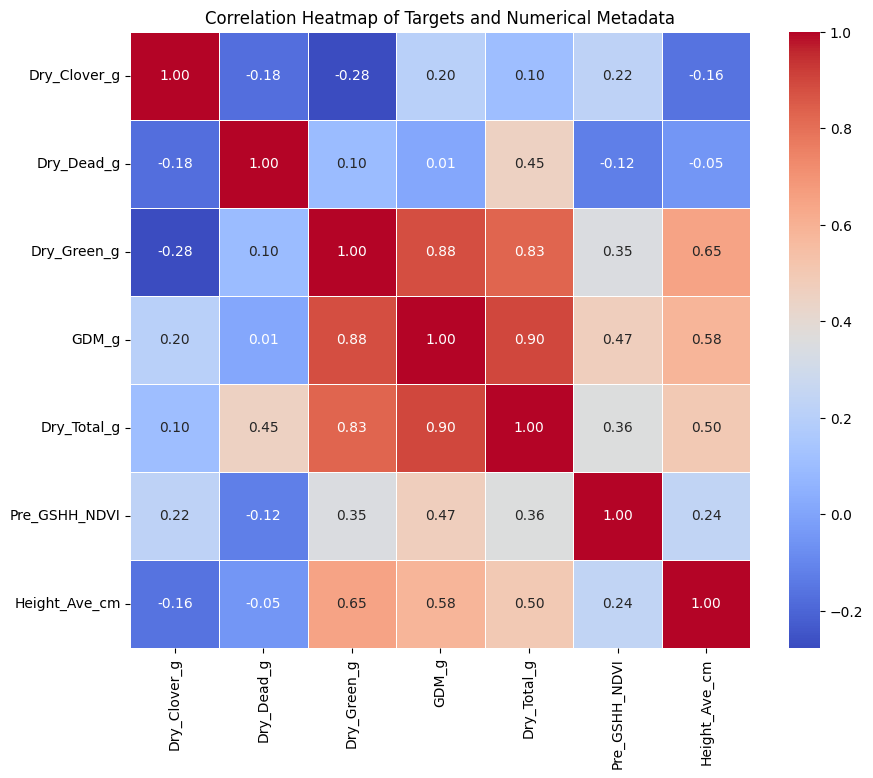

In [17]:
"""
Cell 4a: EDA - Correlation Heatmap
Reload the original (non-log) data and plot the correlation heatmap
of all numerical features and targets.
"""

# We need to reload the *original* wide-format data for this,
# as the log-transformed data from Cell 4 won't show the real distributions.
try:
    print("Loading and reshaping data for EDA...")
    # --- Re-create train_data_wide (from Cell 3) ---
    _train_df_long = pd.read_csv(os.path.join(BASE_PATH, "train.csv"))
    
    _targets_df = _train_df_long.pivot_table(
        index='image_path',
        columns='target_name',
        values='target'
    ).reset_index()
    
    _metadata_cols = ['image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm']
    _metadata_df = _train_df_long[_metadata_cols].drop_duplicates(subset=['image_path'])
    
    # This DataFrame will be used by the next cells
    _train_data_wide = pd.merge(_metadata_df, _targets_df, on='image_path')
    
    _num_metadata_cols = ['Pre_GSHH_NDVI', 'Height_Ave_cm']
    print("Data loaded successfully.")
    # --- End of re-creation ---

    # Plot 1: Correlation Heatmap
    print("Generating Correlation Heatmap...")
    plt.figure(figsize=(10, 8))
    corr_matrix = _train_data_wide[TARGET_COLS + _num_metadata_cols].corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Heatmap of Targets and Numerical Metadata')
    plt.savefig("correlation_heatmap.png", dpi=150)
    print("Saved 'correlation_heatmap.png'")
    plt.show()

except Exception as e:
    print(f"An error occurred during EDA (Cell 4a): {e}")

Generating Key Relationship Scatter Plots...
Saved 'scatter_plots.png'


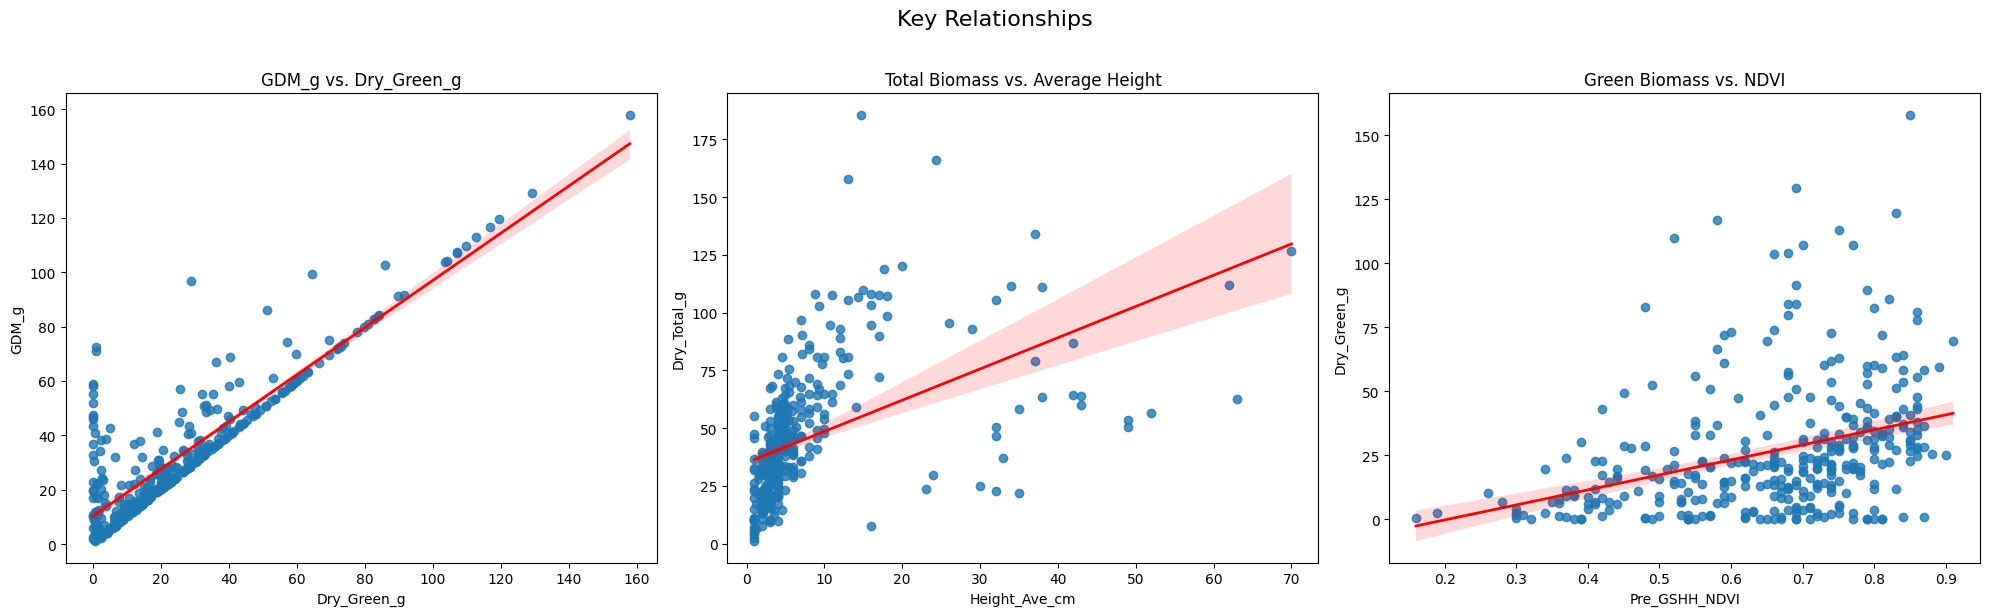

In [18]:
"""
Cell 4b: EDA - Key Relationship Scatter Plots
Uses the _train_data_wide DataFrame from the previous cell.
"""

try:
    if '_train_data_wide' in locals():
        print("Generating Key Relationship Scatter Plots...")
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        fig.suptitle('Key Relationships', fontsize=16, y=1.02)
        
        sns.regplot(data=_train_data_wide, x='Dry_Green_g', y='GDM_g', ax=axes[0],
                    line_kws={"color": "red", "lw": 2})
        axes[0].set_title('GDM_g vs. Dry_Green_g')
        
        sns.regplot(data=_train_data_wide, x='Height_Ave_cm', y='Dry_Total_g', ax=axes[1],
                    line_kws={"color": "red", "lw": 2})
        axes[1].set_title('Total Biomass vs. Average Height')
        
        sns.regplot(data=_train_data_wide, x='Pre_GSHH_NDVI', y='Dry_Green_g', ax=axes[2],
                    line_kws={"color": "red", "lw": 2})
        axes[2].set_title('Green Biomass vs. NDVI')
        
        plt.tight_layout()
        plt.savefig("scatter_plots.png", dpi=150)
        print("Saved 'scatter_plots.png'")
        plt.show()
    else:
        print("Please run Cell 4a first to load the _train_data_wide DataFrame.")

except Exception as e:
    print(f"An error occurred during EDA (Cell 4b): {e}")

Generating Categorical Box Plots...
Saved 'box_plots.png'


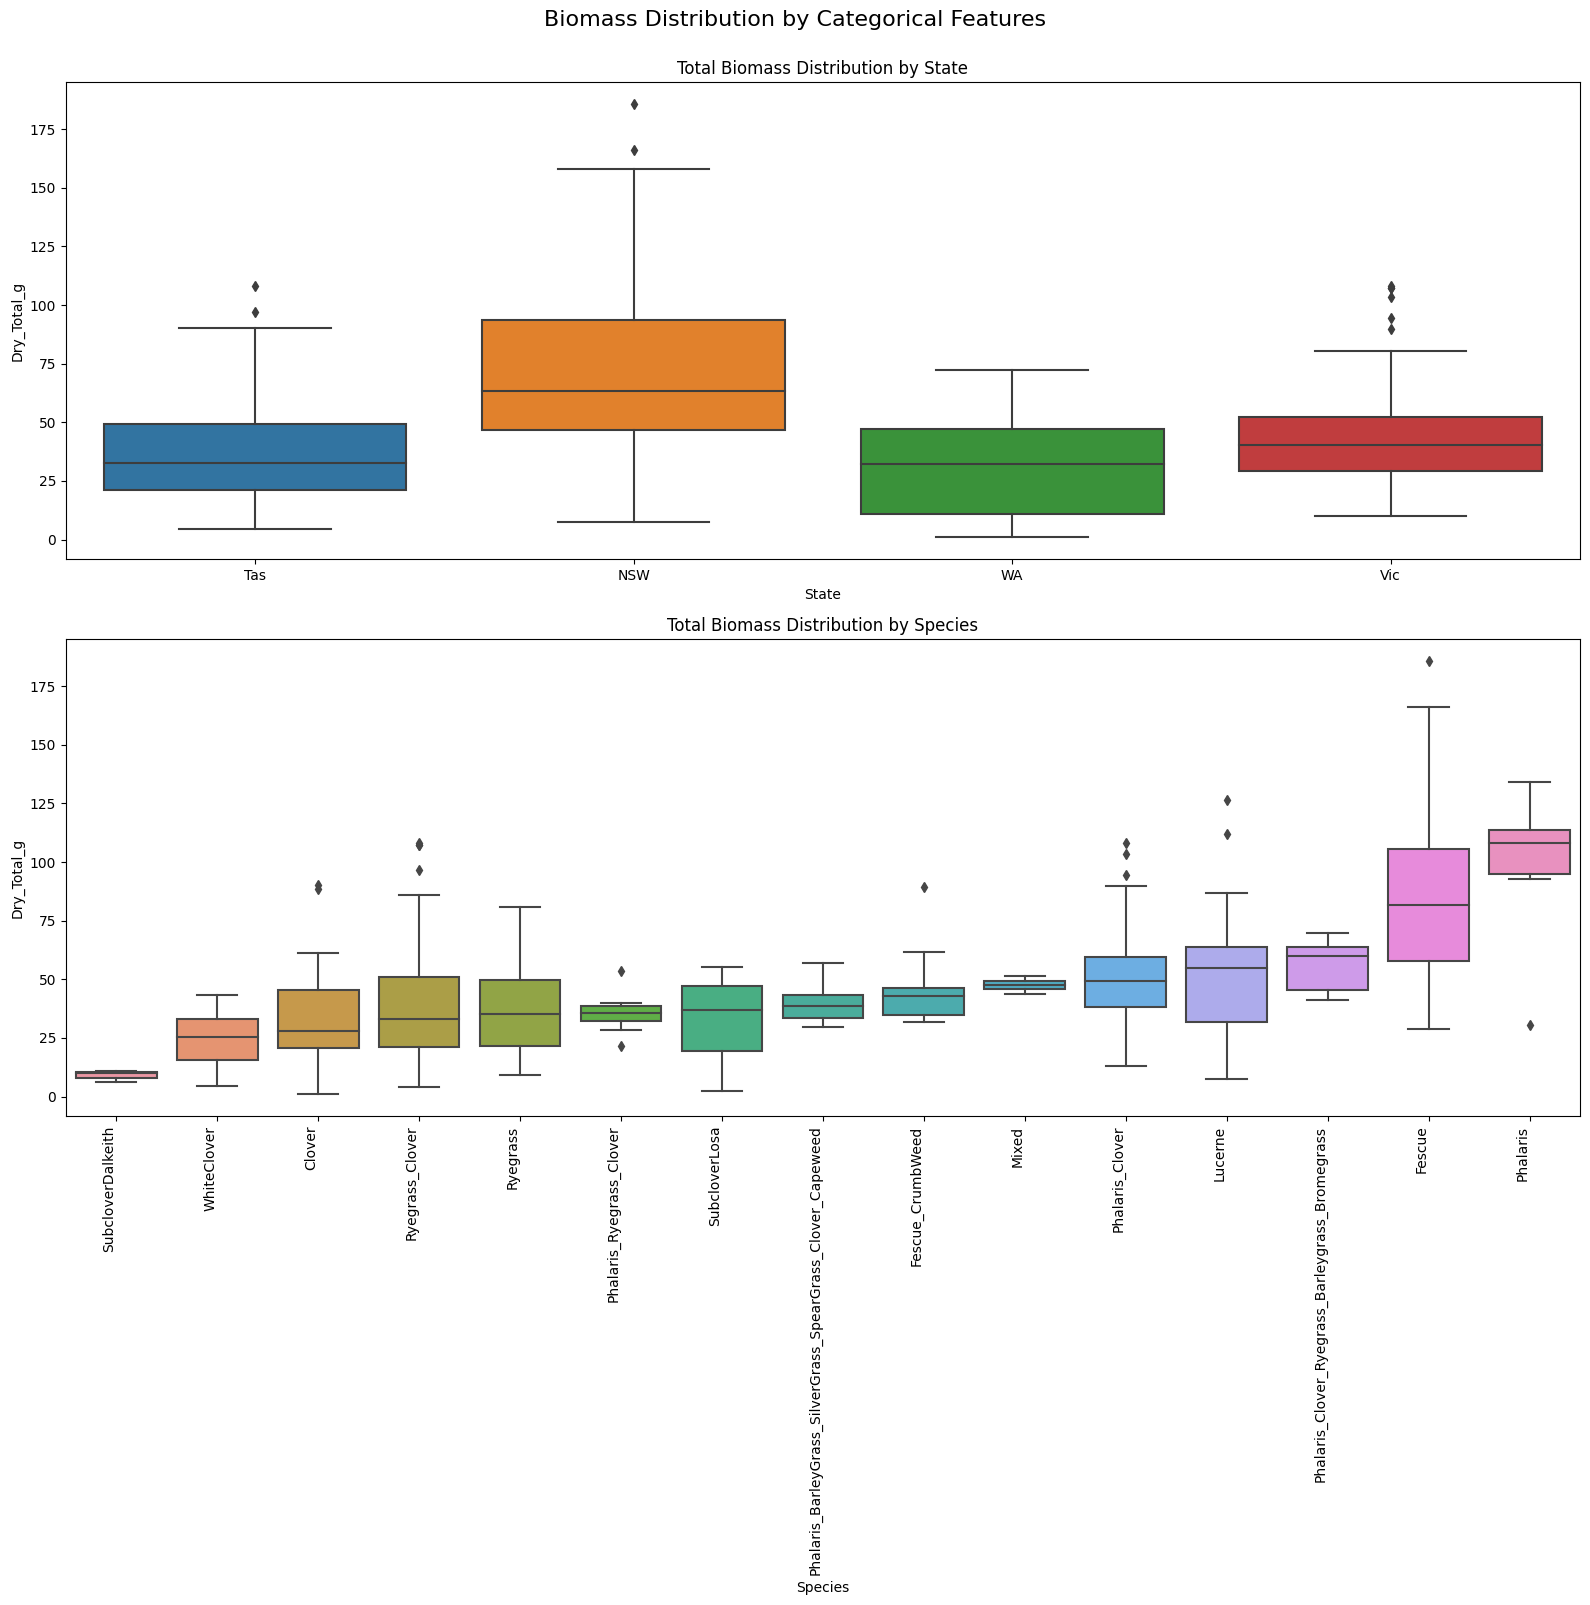

In [19]:
"""
Cell 4c: EDA - Categorical Box Plots
Uses the _train_data_wide DataFrame from Cell 4a.
"""

try:
    if '_train_data_wide' in locals():
        print("Generating Categorical Box Plots...")
        fig, axes = plt.subplots(2, 1, figsize=(16, 16))
        fig.suptitle('Biomass Distribution by Categorical Features', fontsize=16, y=1.0)
        
        # Plot 1: State vs Dry_Total_g
        sns.boxplot(data=_train_data_wide, x='State', y='Dry_Total_g', ax=axes[0])
        axes[0].set_title('Total Biomass Distribution by State')
        
        # Plot 2: Species vs Dry_Total_g
        # Order by median value to make it easier to read
        species_order = _train_data_wide.groupby('Species')['Dry_Total_g'].median().sort_values().index
        sns.boxplot(data=_train_data_wide, x='Species', y='Dry_Total_g', ax=axes[1], order=species_order)
        axes[1].set_title('Total Biomass Distribution by Species')
        axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, ha='right')
        
        plt.tight_layout()
        plt.savefig("box_plots.png", dpi=150)
        print("Saved 'box_plots.png'")
        plt.show()
    else:
        print("Please run Cell 4a first to load the _train_data_wide DataFrame.")
        
except Exception as e:
    print(f"An error occurred during EDA (Cell 4c): {e}")

Loading prerequisite data...
Prerequisite data loaded.
Generating sample images by State...
Saved 'sample_images_by_state.png'


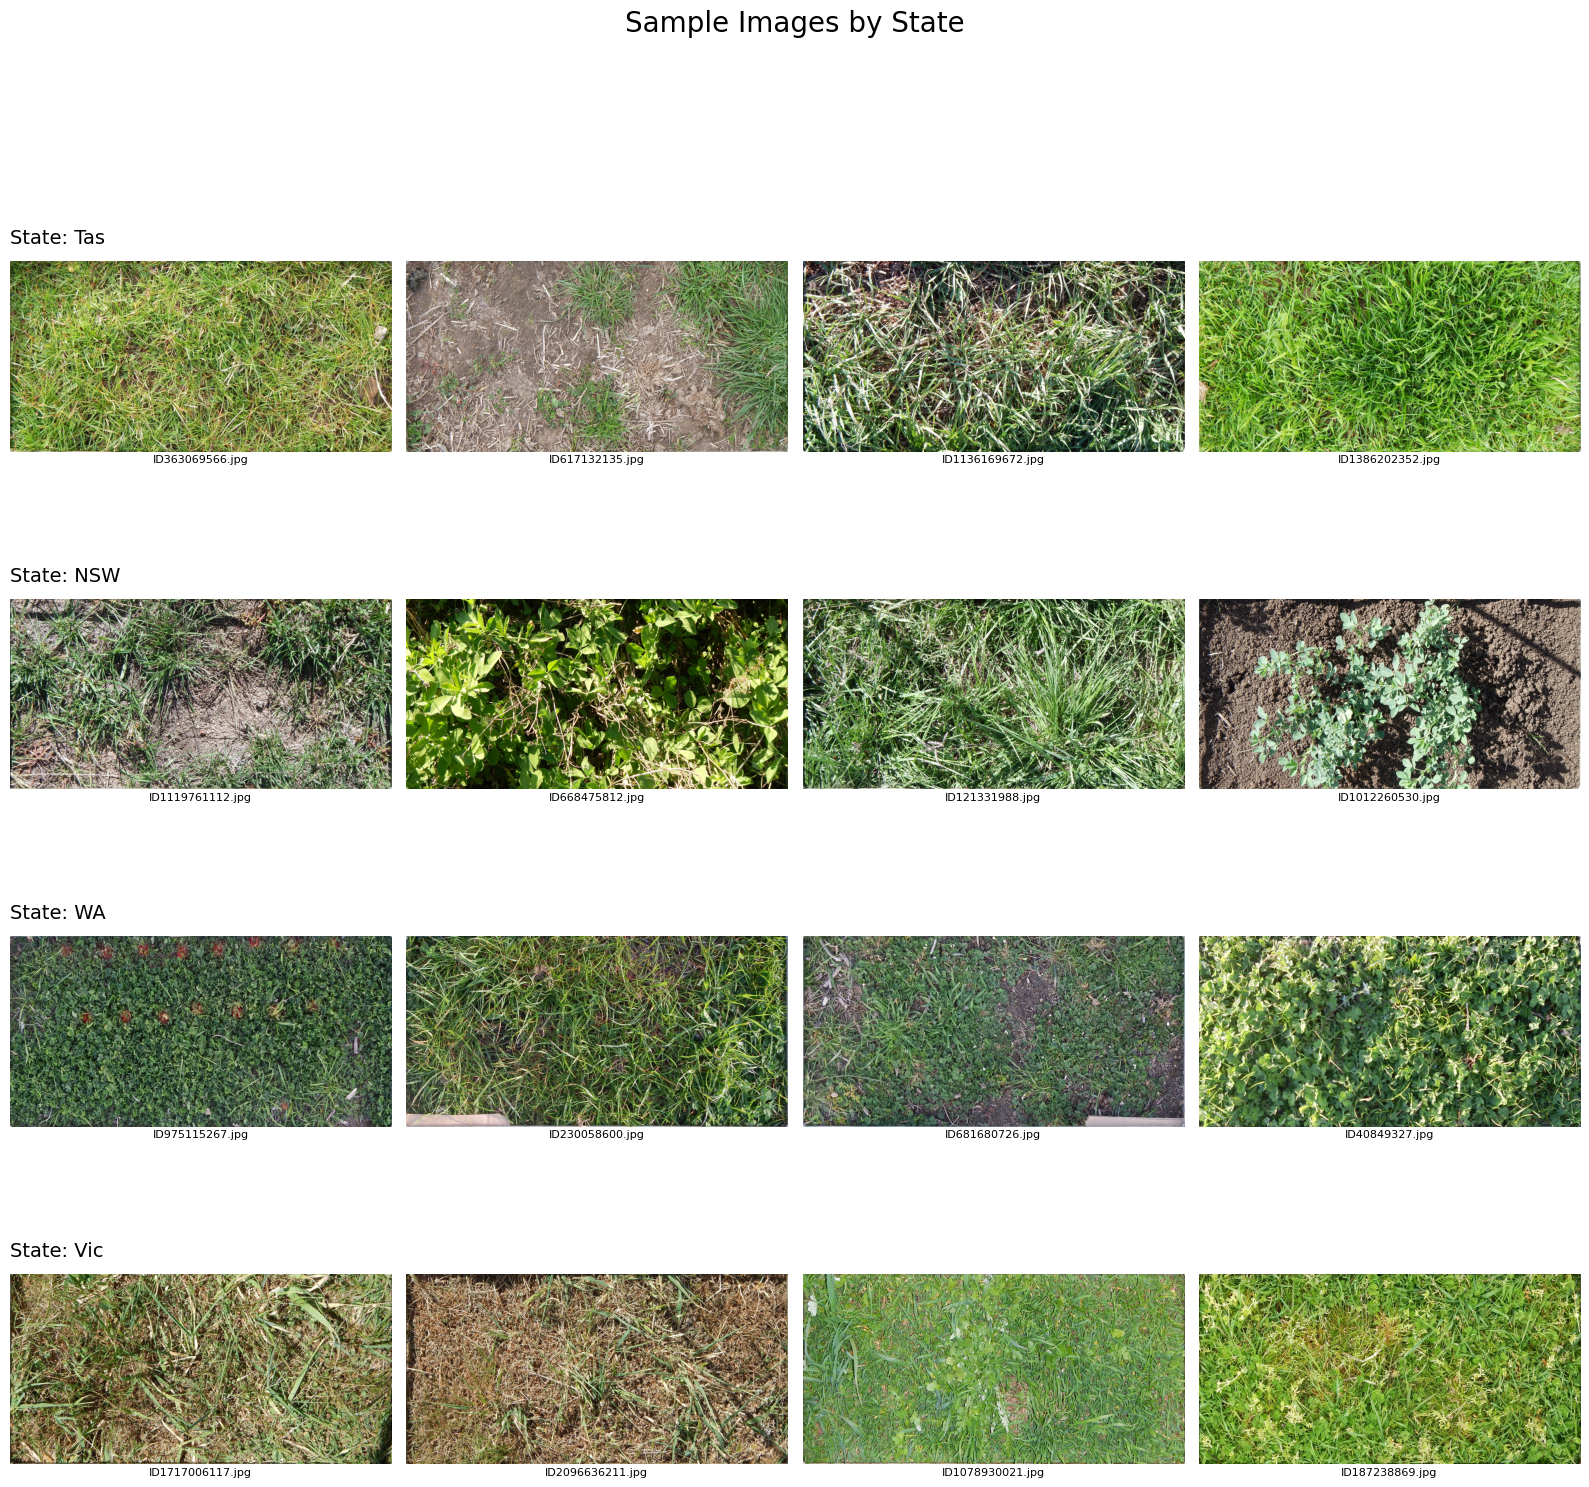

In [20]:
"""
Cell 4d: EDA - Sample Images by State
Plots a grid of sample images, showing 4 examples from each of the 4 states.
"""
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from PIL import Image

try:
    # --- Setup code from Cell 2 and 4a ---
    print("Loading prerequisite data...")
    SEED = 42
    BASE_PATH = "/kaggle/input/csiro-biomass/"
    TARGET_COLS = ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'GDM_g', 'Dry_Total_g']

    _train_df_long = pd.read_csv(os.path.join(BASE_PATH, "train.csv"))
    
    _targets_df = _train_df_long.pivot_table(
        index='image_path',
        columns='target_name',
        values='target'
    ).reset_index()
    
    _metadata_cols = ['image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm']
    _metadata_df = _train_df_long[_metadata_cols].drop_duplicates(subset=['image_path'])
    
    _train_data_wide = pd.merge(_metadata_df, _targets_df, on='image_path')
    print("Prerequisite data loaded.")
    # --- End of setup code ---

    print("Generating sample images by State...")
    
    # Get the 4 states
    states = _train_data_wide['State'].unique()
    num_states = len(states)
    num_samples = 4 # We'll show 4 samples per state
    
    fig, axes = plt.subplots(num_states, num_samples, figsize=(16, 16))
    if num_states == 1: # Handle case of only one state
        axes = np.array([axes])

    fig.suptitle('Sample Images by State', fontsize=20, y=1.02)
    
    for i, state in enumerate(states):
        # Get 4 random sample images from this state
        # Ensure we don't try to sample more than available
        state_df = _train_data_wide[_train_data_wide['State'] == state]
        n_available = len(state_df)
        samples_to_take = min(num_samples, n_available)
        
        if n_available > 0:
            sample_df = state_df.sample(samples_to_take, random_state=SEED)
        
            for j, (idx, row) in enumerate(sample_df.iterrows()):
                # Construct the full image path
                img_path = os.path.join(BASE_PATH, row['image_path'])
                
                try:
                    img = Image.open(img_path)
                except FileNotFoundError:
                    # Create a placeholder if image is missing
                    img = Image.new('RGB', (224, 224), color='gray')
                    print(f"Warning: Could not find {img_path}")
                
                # Plot the image
                ax = axes[i, j]
                ax.imshow(img)
                ax.axis('off')
                
                # Set title for the first image in each row to the state name
                if j == 0:
                    # Use a y value that's slightly above the plot
                    ax.set_title(f"State: {state}", loc='left', fontsize=14, y=1.05)
                
                # Add image ID as a smaller title below the main one
                img_id = row['image_path'].split('/')[-1]
                ax.set_title(img_id, fontsize=8, y=-0.1) # Place at bottom

    # Handle empty subplots if some states had < 4 samples
    for ax_row in axes:
        for ax in ax_row:
            if not ax.images:
                ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout for suptitle
    plt.savefig("sample_images_by_state.png", dpi=150)
    print("Saved 'sample_images_by_state.png'")
    plt.show()

except Exception as e:
    print(f"An error occurred during EDA (Cell 4d): {e}")

Generating Pair Plot... (This may take a moment)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

Saved 'pair_plot.png'


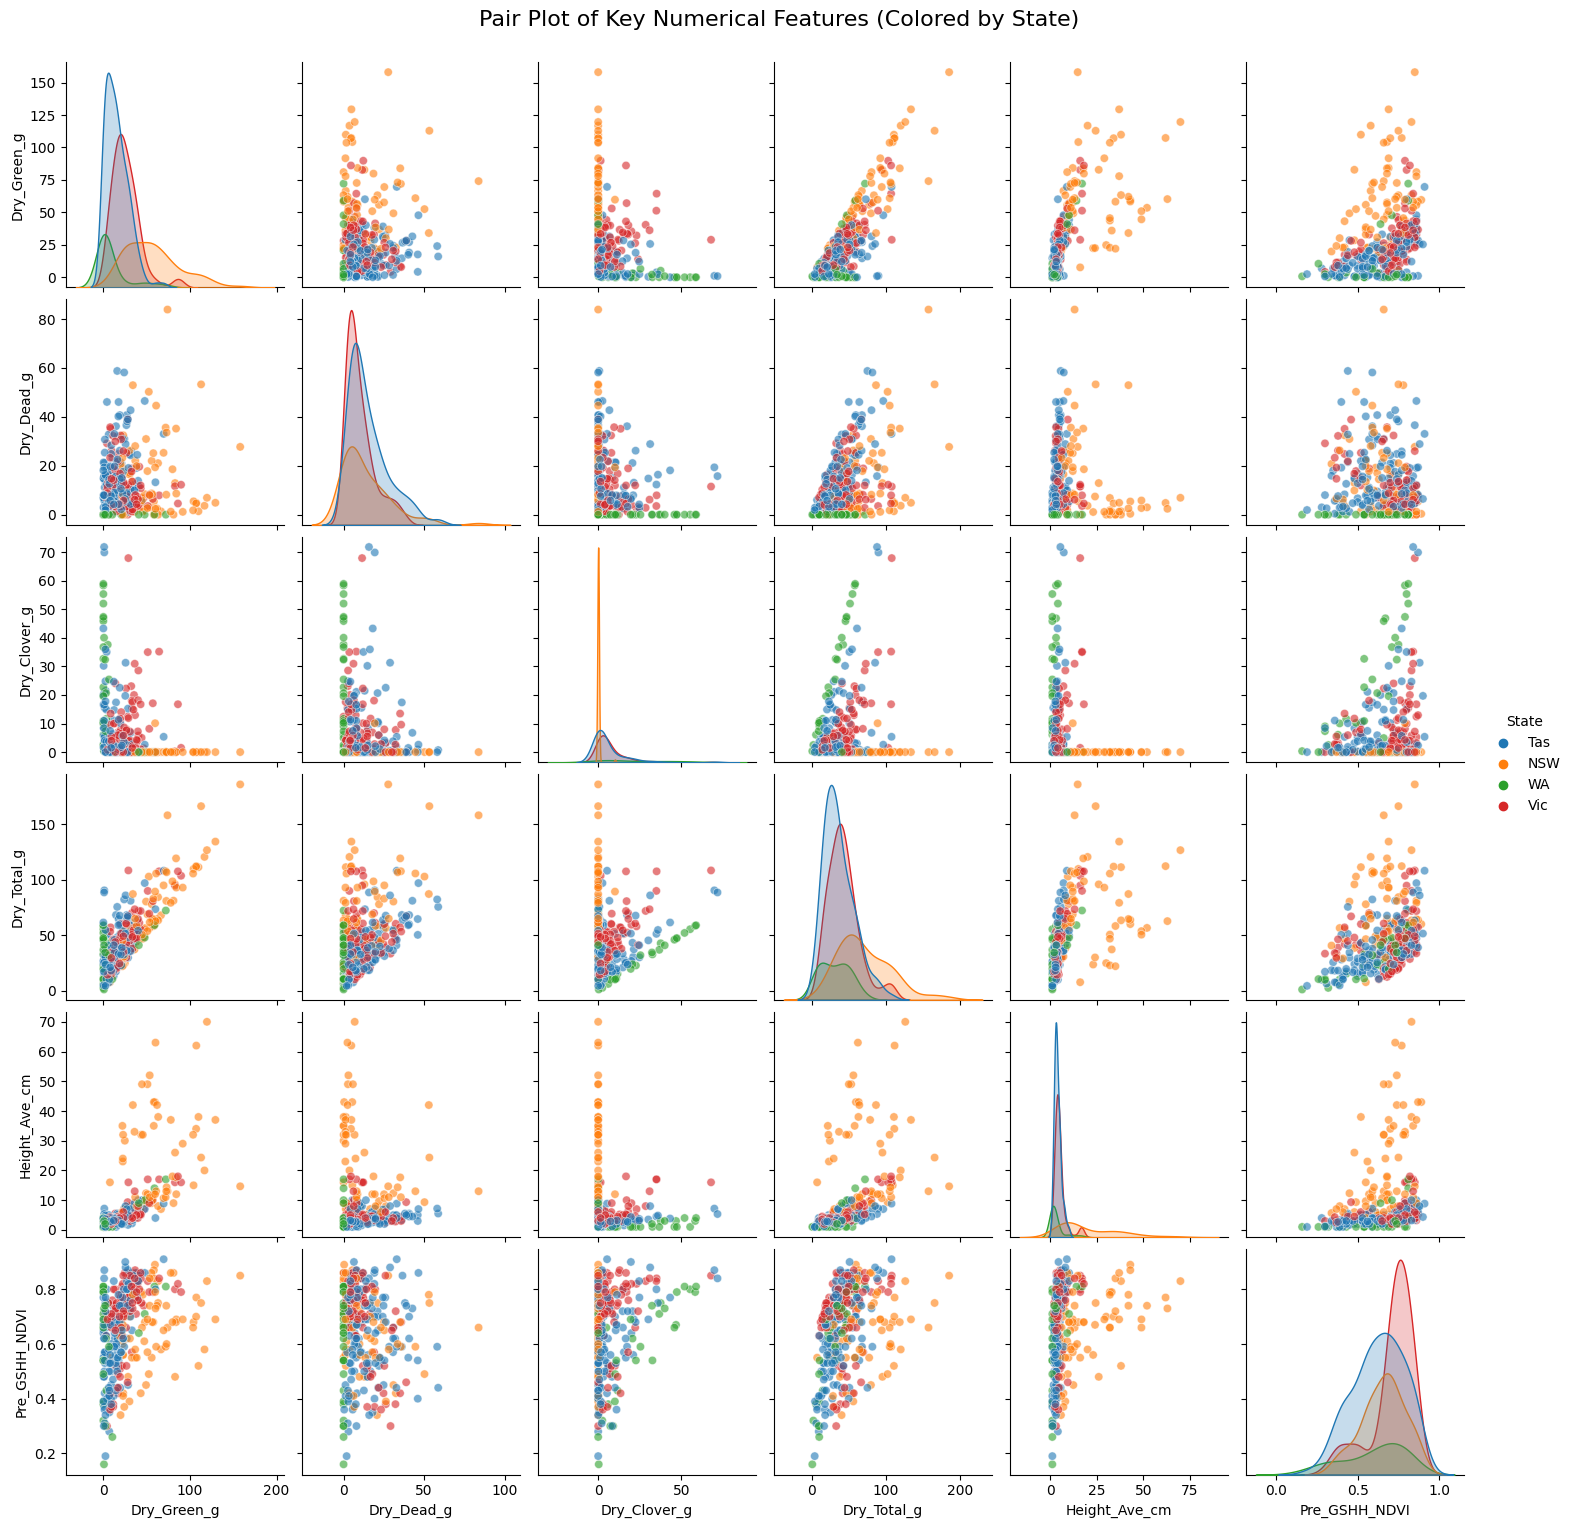

In [22]:
"""
Cell 4e: EDA - Pair Plot of All Numerical Features
Shows the bivariate relationship between all targets and numerical metadata.
"""

try:
    # --- Check if _train_data_wide exists, if not, create it ---
    if '_train_data_wide' not in locals():
        print("Loading and reshaping data for EDA...")
        # --- Setup code from Cell 2 and 4a ---
        BASE_PATH = "/kaggle/input/csiro-biomass/"
        _train_df_long = pd.read_csv(os.path.join(BASE_PATH, "train.csv"))
        
        _targets_df = _train_df_long.pivot_table(
            index='image_path',
            columns='target_name',
            values='target'
        ).reset_index()
        
        _metadata_cols = ['image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm']
        _metadata_df = _train_df_long[_metadata_cols].drop_duplicates(subset=['image_path'])
        
        _train_data_wide = pd.merge(_metadata_df, _targets_df, on='image_path')
        _num_metadata_cols = ['Pre_GSHH_NDVI', 'Height_Ave_cm']
        print("Data loaded successfully.")
        # --- End of setup code ---
    
    # --- Plot 1: Pair Plot ---
    print("Generating Pair Plot... (This may take a moment)")
    
    # We'll use a subset of columns to keep it readable
    plot_cols = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'Dry_Total_g', 'Height_Ave_cm', 'Pre_GSHH_NDVI']
    
    # Create the pairplot, hue by 'State' to add another dimension
    pair_plot_fig = sns.pairplot(_train_data_wide, vars=plot_cols, hue='State', plot_kws={'alpha': 0.6})
    
    pair_plot_fig.fig.suptitle('Pair Plot of Key Numerical Features (Colored by State)', y=1.02, fontsize=16)
    
    plt.savefig("pair_plot.png", dpi=100) # Use lower DPI for large plots
    print("Saved 'pair_plot.png'")
    plt.show()

except Exception as e:
    print(f"An error occurred during EDA (Cell 4e): {e}")

Generating Joint Plot for Height vs. Total Biomass...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Saved 'joint_plot_height_biomass.png'


<Figure size 1000x1000 with 0 Axes>

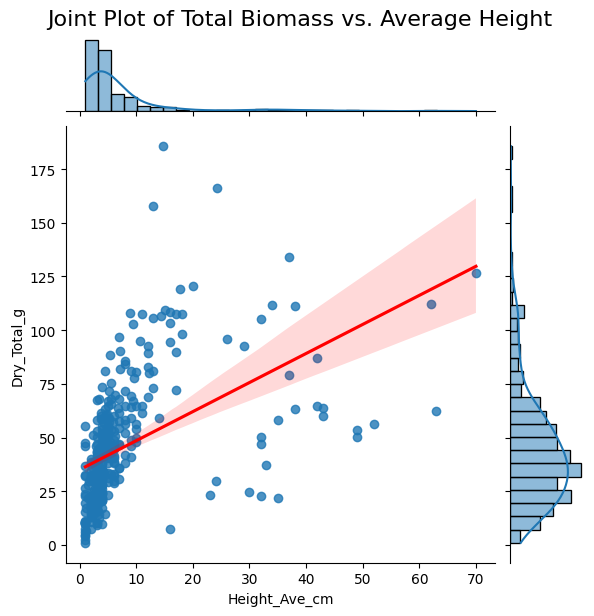

In [23]:
"""
Cell 4f: EDA - Joint Plot for Height vs. Total Biomass
Deep-dives into the relationship between average height and total biomass.
"""

try:
    # --- Check if _train_data_wide exists (it should from Cell 4e) ---
    if '_train_data_wide' in locals():
        print("Generating Joint Plot for Height vs. Total Biomass...")
        
        # Create the jointplot
        plt.figure(figsize=(10, 10)) # Set figure size before jointplot
        
        joint_plot_fig = sns.jointplot(
            data=_train_data_wide,
            x='Height_Ave_cm',
            y='Dry_Total_g',
            kind='reg', # 'reg' adds a regression line and confidence interval
            joint_kws={'line_kws': {'color': 'red'}},
            marginal_kws={'bins': 30, 'kde': True}
        )
        
        joint_plot_fig.fig.suptitle('Joint Plot of Total Biomass vs. Average Height', y=1.02, fontsize=16)
        
        plt.savefig("joint_plot_height_biomass.png", dpi=150)
        print("Saved 'joint_plot_height_biomass.png'")
        plt.show()
    
    else:
        print("Please run Cell 4a or 4e first to load the _train_data_wide DataFrame.")

except Exception as e:
    print(f"An error occurred during EDA (Cell 4f): {e}")

--- Inspecting one batch from train_loader ---
Saved 'batch_sample.png' with sample images and labels.

--- Labels for first image (Image 0) ---
Target Name     | Log (Model Input)    | Original (grams)    
-----------------------------------------------------------
Dry_Clover_g    | 1.6460               | 4.19                
Dry_Dead_g      | 2.5267               | 11.51               
Dry_Green_g     | 2.4393               | 10.47               
GDM_g           | 2.7505               | 14.65               
Dry_Total_g     | 3.3018               | 26.16               


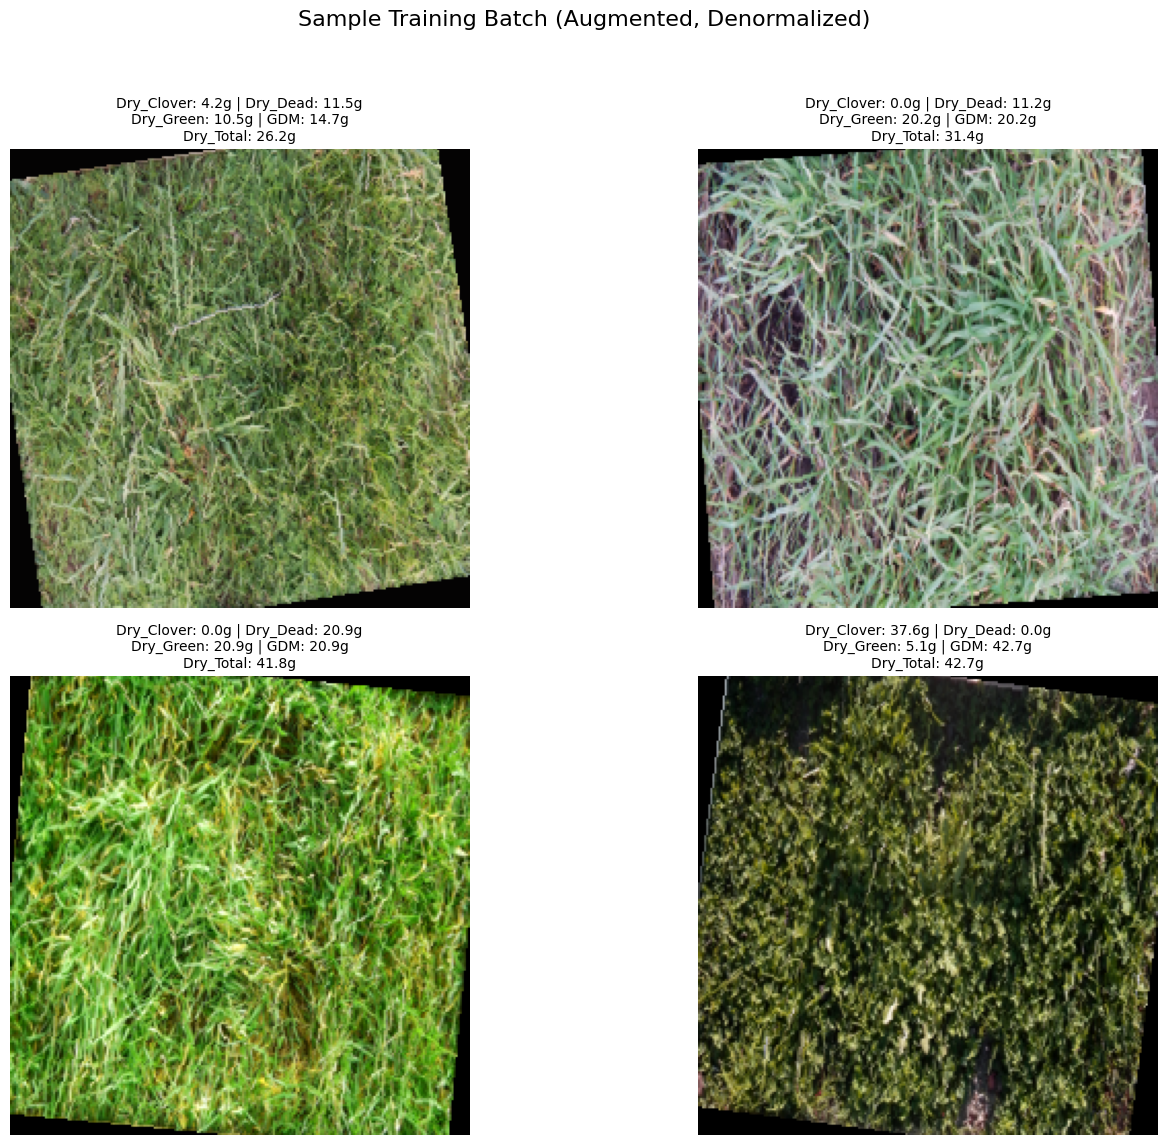

In [9]:
"""
Cell 7a: Inspect a Training Batch
Load one batch from the train_loader, convert the image tensors back to
PIL Images, and display them with their corresponding labels.
"""

def denormalize_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Reverses the ImageNet normalization on a tensor."""
    # Clone the tensor to avoid modifying the original
    tensor = tensor.clone()
    
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    
    # tensor = (tensor * std) + mean
    # This is equivalent to:
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
        
    return tensor

def tensor_to_pil(tensor):
    """Converts a normalized image tensor back to a PIL Image."""
    # 1. Denormalize the image
    tensor = denormalize_image(tensor.cpu())
    
    # 2. Clamp values to [0, 1] range just in case
    tensor = torch.clamp(tensor, 0, 1)
    
    # 3. Permute from (C, H, W) to (H, W, C) for PIL
    tensor = tensor.permute(1, 2, 0)
    
    # 4. Scale to [0, 255] and convert to uint8 NumPy array
    image_np = (tensor.numpy() * 255).astype(np.uint8)
    
    # 5. Create PIL Image
    pil_image = Image.fromarray(image_np)
    
    return pil_image

if 'train_loader' in locals():
    print("--- Inspecting one batch from train_loader ---")
    
    # Get one batch
    try:
        images, labels = next(iter(train_loader))
        
        # --- Plot 4 images from the batch ---
        plt.figure(figsize=(15, 12))
        plt.suptitle("Sample Training Batch (Augmented, Denormalized)", fontsize=16)
        
        for i in range(min(4, len(images))):
            # 1. Get the tensor
            image_tensor = images[i]
            label_tensor = labels[i]
            
            # 2. Convert tensor to PIL Image (as requested)
            pil_image = tensor_to_pil(image_tensor)
            
            # 3. Get original labels (reversing log1p)
            original_labels = np.expm1(label_tensor.numpy())
            
            # 4. Plot using matplotlib
            ax = plt.subplot(2, 2, i + 1)
            plt.imshow(pil_image)
            
            # Create title
            title = f"Dry_Clover: {original_labels[0]:.1f}g | Dry_Dead: {original_labels[1]:.1f}g\n"
            title += f"Dry_Green: {original_labels[2]:.1f}g | GDM: {original_labels[3]:.1f}g\n"
            title += f"Dry_Total: {original_labels[4]:.1f}g"
            ax.set_title(title, fontsize=10)
            ax.axis('off')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig("batch_sample.png")
        print("Saved 'batch_sample.png' with sample images and labels.\n")

        # --- Print details for the first image ---
        print(f"--- Labels for first image (Image 0) ---")
        first_label_log = labels[0].numpy()
        first_label_original = np.expm1(first_label_log)
        
        print(f"{'Target Name':<15} | {'Log (Model Input)':<20} | {'Original (grams)':<20}")
        print("-" * 59)
        for i, col in enumerate(TARGET_COLS):
            print(f"{col:<15} | {first_label_log[i]:<20.4f} | {first_label_original[i]:<20.2f}")

    except Exception as e:
        print(f"An error occurred while trying to load a batch: {e}")
        print("This might happen if the DataLoader workers failed.")
else:
     print("train_loader not found. Please run Cell 7 first.")

In [11]:
"""
Cell 8: Define the Model
We load a pre-trained EfficientNet-B0 and replace the final classifier
with a simple Linear layer that outputs 5 values (for our 5 targets).
"""

def get_model():
    # Load a pre-trained EfficientNet-B0
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    
    # Freeze the backbone features
    for param in model.features.parameters():
        param.requires_grad = False
        
    # Get the number of input features for the classifier
    in_features = model.classifier[1].in_features
    
    # Replace the classifier with a new regression head
    # We use a simple Linear layer
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True), # Add dropout for regularization
        nn.Linear(in_features, 5)       # Output 5 values
    )
    
    return model

model = get_model().to(DEVICE)

# Test with a dummy input
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)
output = model(dummy_input)
print(f"Model loaded. Output shape for 1 image: {output.shape}")

Model loaded. Output shape for 1 image: torch.Size([1, 5])


In [13]:
ls

best_model.pth


In [12]:
"""
Cell 9: Define Weighted Loss and Training Loop
We create a custom Weighted MSE loss that mimics the competition's
evaluation metric. We also define our train and validation functions.
"""

def weighted_mse_loss(preds, targets, weights):
    """
    Calculates weighted MSE.
    preds: (batch_size, 5)
    targets: (batch_size, 5)
    weights: (5,)
    """
    # Calculate MSE for each target
    loss = (preds - targets) ** 2
    
    # Apply weights
    # (batch_size, 5) * (5,) -> (batch_size, 5)
    weighted_loss = loss * weights
    
    # Return the mean of the weighted losses
    return torch.mean(weighted_loss)


def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    
    for images, targets in tqdm(loader, desc="Training"):
        images, targets = images.to(DEVICE), targets.to(DEVICE)
        
        # Forward pass
        preds = model(images)
        loss = loss_fn(preds, targets, EVAL_WEIGHTS)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(loader)


def validate_one_epoch(model, loader, loss_fn):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for images, targets in tqdm(loader, desc="Validating"):
            images, targets = images.to(DEVICE), targets.to(DEVICE)
            
            # Forward pass
            preds = model(images)
            loss = loss_fn(preds, targets, EVAL_WEIGHTS)
            
            total_loss += loss.item()
            
    return total_loss / len(loader)

print("Loss function and train/validate functions defined.")

Loss function and train/validate functions defined.


In [13]:
"""
Cell 10: Run the Training
We instantiate the model, optimizer, and run the training loop,
saving the best model based on validation loss.
"""

if 'train_loader' in locals():
    # Re-initialize model, optimizer
    model = get_model().to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    best_val_loss = float('inf')
    best_model_path = "best_model.pth"

    print("Starting training...")

    for epoch in range(1, EPOCHS + 1):
        start_time = time.time()
        
        train_loss = train_one_epoch(model, train_loader, optimizer, weighted_mse_loss)
        val_loss = validate_one_epoch(model, val_loader, weighted_mse_loss)
        
        elapsed = time.time() - start_time
        
        print(f"Epoch {epoch}/{EPOCHS} - {elapsed:.0f}s - "
              f"Train Loss: {train_loss:.4f} - "
              f"Val Loss: {val_loss:.4f}")
        
        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"   *** New best model saved to {best_model_path} with Val Loss: {val_loss:.4f} ***")

    print(f"\nTraining complete. Best validation loss: {best_val_loss:.4f}")
else:
    print("DataLoaders not found. Please run all previous cells.")

Starting training...


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/20 - 29s - Train Loss: 2.0239 - Val Loss: 1.8904
   *** New best model saved to best_model.pth with Val Loss: 1.8904 ***


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/20 - 21s - Train Loss: 1.6561 - Val Loss: 1.5915
   *** New best model saved to best_model.pth with Val Loss: 1.5915 ***


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/20 - 21s - Train Loss: 1.3455 - Val Loss: 1.3304
   *** New best model saved to best_model.pth with Val Loss: 1.3304 ***


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/20 - 22s - Train Loss: 1.1068 - Val Loss: 1.1353
   *** New best model saved to best_model.pth with Val Loss: 1.1353 ***


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/20 - 21s - Train Loss: 0.9060 - Val Loss: 0.9911
   *** New best model saved to best_model.pth with Val Loss: 0.9911 ***


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/20 - 22s - Train Loss: 0.7524 - Val Loss: 0.9230
   *** New best model saved to best_model.pth with Val Loss: 0.9230 ***


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/20 - 22s - Train Loss: 0.6554 - Val Loss: 0.8328
   *** New best model saved to best_model.pth with Val Loss: 0.8328 ***


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/20 - 21s - Train Loss: 0.5712 - Val Loss: 0.7221
   *** New best model saved to best_model.pth with Val Loss: 0.7221 ***


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9/20 - 21s - Train Loss: 0.4936 - Val Loss: 0.6648
   *** New best model saved to best_model.pth with Val Loss: 0.6648 ***


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/20 - 22s - Train Loss: 0.4572 - Val Loss: 0.6119
   *** New best model saved to best_model.pth with Val Loss: 0.6119 ***


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11/20 - 23s - Train Loss: 0.4674 - Val Loss: 0.5659
   *** New best model saved to best_model.pth with Val Loss: 0.5659 ***


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12/20 - 23s - Train Loss: 0.4018 - Val Loss: 0.5212
   *** New best model saved to best_model.pth with Val Loss: 0.5212 ***


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13/20 - 23s - Train Loss: 0.3982 - Val Loss: 0.5798


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14/20 - 23s - Train Loss: 0.3846 - Val Loss: 0.5300


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/20 - 22s - Train Loss: 0.3795 - Val Loss: 0.4979
   *** New best model saved to best_model.pth with Val Loss: 0.4979 ***


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16/20 - 22s - Train Loss: 0.3785 - Val Loss: 0.5066


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17/20 - 22s - Train Loss: 0.3655 - Val Loss: 0.5004


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18/20 - 22s - Train Loss: 0.3635 - Val Loss: 0.4839
   *** New best model saved to best_model.pth with Val Loss: 0.4839 ***


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19/20 - 23s - Train Loss: 0.3696 - Val Loss: 0.4930


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/20 - 21s - Train Loss: 0.3617 - Val Loss: 0.4802
   *** New best model saved to best_model.pth with Val Loss: 0.4802 ***

Training complete. Best validation loss: 0.4802


In [14]:
"""
Cell 11: Prediction and Submission
Load the best model, predict on the test set, inverse-transform
the predictions, and create the final submission.csv file.
"""

if 'test_df_long' in locals() and os.path.exists("best_model.pth"):
    # 1. Create a test dataset in the "wide" format
    # We just need the unique image paths
    test_image_paths = test_df_long[['image_path']].drop_duplicates().reset_index(drop=True)

    # 2. Create test dataset and loader
    # *** MODIFIED: Pass the BASE_PATH to the dataset ***
    test_dataset = PastureDataset(test_image_paths,
                                  base_path=BASE_PATH,
                                  transforms=data_transforms['val'], 
                                  is_test=True)
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=BATCH_SIZE * 2, # Can use larger batch for inference
                             shuffle=False, 
                             num_workers=2)

    # 3. Load the best model
    model = get_model().to(DEVICE)
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()

    # 4. Get predictions
    all_preds = []
    with torch.no_grad():
        for images in tqdm(test_loader, desc="Predicting"):
            images = images.to(DEVICE)
            preds = model(images)
            all_preds.append(preds.cpu().numpy())
    
    # Concatenate all batch predictions
    raw_predictions = np.concatenate(all_preds, axis=0)
    
    # 5. Inverse transform the predictions: exp(x) - 1
    # This is the reverse of np.log1p(x)
    final_predictions = np.expm1(raw_predictions)
    
    # Ensure no negative values (can happen due to float errors)
    final_predictions[final_predictions < 0] = 0

    # 6. Create the submission file in the correct format
    
    # Add predictions to our test_image_paths_df
    preds_df = pd.DataFrame(final_predictions, columns=TARGET_COLS)
    test_pred_wide_df = pd.concat([test_image_paths, preds_df], axis=1)

    # Melt the wide DataFrame back to the "long" format
    submission_df = test_pred_wide_df.melt(
        id_vars=['image_path'],
        value_vars=TARGET_COLS,
        var_name='target_name',
        value_name='target'
    )
    
    # We need to map this back to the original sample_id from test_df_long
    # Merge with test_df_long on image_path and target_name
    final_submission = pd.merge(
        test_df_long[['sample_id', 'image_path', 'target_name']],
        submission_df,
        on=['image_path', 'target_name']
    )
    
    # Select only the required columns
    final_submission = final_submission[['sample_id', 'target']]
    
    # Save to CSV
    final_submission.to_csv("submission.csv", index=False)
    
    print("\n--- Final Submission File Head ---")
    print(final_submission.head())
    print("\n'submission.csv' created successfully!")

else:
    print("Could not find 'test_df_long' or 'best_model.pth'.")
    print("Please run all previous cells and ensure training completed.")

Predicting:   0%|          | 0/1 [00:00<?, ?it/s]


--- Final Submission File Head ---
                    sample_id     target
0  ID1001187975__Dry_Clover_g   0.220955
1    ID1001187975__Dry_Dead_g   7.660419
2   ID1001187975__Dry_Green_g  12.244169
3   ID1001187975__Dry_Total_g  15.751701
4         ID1001187975__GDM_g  11.652205

'submission.csv' created successfully!


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 271, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times
